In [11]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-data-set/test/test/id_2005_label_23.png
/kaggle/input/arabic-data-set/test/test/id_363_label_14.png
/kaggle/input/arabic-data-set/test/test/id_42_label_21.png
/kaggle/input/arabic-data-set/test/test/id_202_label_17.png
/kaggle/input/arabic-data-set/test/test/id_1900_label_26.png
/kaggle/input/arabic-data-set/test/test/id_415_label_12.png
/kaggle/input/arabic-data-set/test/test/id_2766_label_11.png
/kaggle/input/arabic-data-set/test/test/id_1152_label_16.png
/kaggle/input/arabic-data-set/test/test/id_2125_label_27.png
/kaggle/input/arabic-data-set/test/test/id_429_label_19.png
/kaggle/input/arabic-data-set/test/test/id_2552_label_16.png
/kaggle/input/arabic-data-set/test/test/id_1922_label_9.png
/kaggle/input/arabic-data-set/test/test/id_1447_label_24.png
/kaggle/input/arabic-data-set/test/test/id_2609_label_17.png
/kaggle/input/arabic-data-set/test/test/id_1477_label_11.png
/kaggle/input/arabic-data-set/test/test/id_3084_label_2.png
/kaggle/input/arabic-data-set/te

In [12]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

In [13]:
train_path = '/kaggle/input/arabic-data-set/train/train/'
test_path = '/kaggle/input/arabic-data-set/test/test/'

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
from PIL import Image


class CustomImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        # Store the filenames and labels
        self.image_filenames = []
        self.labels = []
        for filename in os.listdir(data_dir):
            if filename.endswith('.png'):
                label = int(filename.split('_')[-1].split('.')[0]) - 1
                self.image_filenames.append(filename)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        label = self.labels[idx]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path).convert('L')  # Convert to grayscale

        if self.transform:
            img = self.transform(img)

        return img, label


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])



In [16]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class NoisyImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        # Store the filenames and labels
        self.image_filenames = []
        self.labels = []
        for filename in os.listdir(data_dir):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                # Assuming the label is encoded in the filename before the extension
                label = int(filename.split('_')[-1].split('.')[0]) - 1
                self.image_filenames.append(filename)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        label = self.labels[idx]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        return img, label

def add_gaussian_noise(img_tensor, mean=-0.1, std=0.2):
    noise = torch.randn_like(img_tensor) * std + mean
    return img_tensor + noise

# Define transformations
gaussian_noise_transform = transforms.Compose([
    transforms.Resize((224, 224)) , 
    transforms.ToTensor(),  # Convert image to tensor first
    transforms.Lambda(lambda x: add_gaussian_noise(x))
])




In [19]:
def label_to_letter(label):
    arabic_letters = ['Alef', 'Baa', 'Taa', 'Thaa', 'Jeem', '7aa', 'Khaa', 'Dal', 'Dhal', 'Raa', 'Zain', 'Seen', 'Sheen', 'Saad', 'Daad', 'Taa', 'Dhaa', 'Ain', 'Ghain', 'Faa', 'Qaf', 'Kaf', 'Lam', 'Meem', 'Noon', 'Haa', 'Waw', 'Yaa']
    return arabic_letters[label]
                          
                          
def plot_images(images, labels, predictions, title, n_cols=5):
    n_rows = int(np.ceil(len(images) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle(title, fontsize=16)

    for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
        ax = axes[i // n_cols, i % n_cols]
        ax.imshow(np.transpose(image, (1, 2, 0)))  # Assuming images are in the format (channels, height, width)
        true_letter = label_to_letter(label)
        predicted_letter = label_to_letter(prediction)
        ax.set_title(f'True: {true_letter}\nPredicted: {predicted_letter}')
        ax.axis('off')

    # Remove empty subplots if needed
    for j in range(len(images), n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])

    plt.show()


In [21]:
from torch.utils.data import Dataset, ConcatDataset
from torchvision.transforms import RandomApply, GaussianBlur, ToTensor

rotate_transform = transforms.Compose([
    transforms.RandomRotation(degrees=70),
    transforms.Resize((224, 224)) , 
    transforms.ToTensor()
])

shift_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.67, 1.47)),
    transforms.Resize((224, 224)) , 
    transforms.ToTensor()
])



shear_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, shear=20 , fill = 1 ),
    transforms.Resize((224, 224)) , 
    transforms.ToTensor()
])


blur_transform = transforms.Compose([
    RandomApply([GaussianBlur(kernel_size=3)], p=0.8),
    transforms.Resize((224, 224)) , 
    transforms.ToTensor()
])



# Task 3

# ALEX NET


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

alexnet_model = models.alexnet(weights=None)
alexnet_model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
alexnet_model.classifier[6] = nn.Linear(4096, 28)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=0.001)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model.to(device)
larger_size = (224, 224)

transform = transforms.Compose([
    transforms.Resize(larger_size),
    transforms.ToTensor(),
])


blur_dataset = CustomImageDataset(train_path, transform=blur_transform)


rotate_dataset = CustomImageDataset(train_path, transform=rotate_transform)

shift_dataset = CustomImageDataset(train_path, transform=shift_transform)


noisy_dataset = NoisyImageDataset(train_path, transform=gaussian_noise_transform)

shear_dataset = CustomImageDataset(train_path, transform=shear_transform)

train_image_dataset = CustomImageDataset(train_path, transform=transform)

train_image_dataset_augmented = ConcatDataset([rotate_dataset, shift_dataset, shear_dataset,train_image_dataset,noisy_dataset,blur_dataset])




loader = DataLoader(train_image_dataset_augmented, batch_size= 128, shuffle=True)


test_dataset = CustomImageDataset(test_path, transform=transform)

test_loader = DataLoader(test_dataset, batch_size= 1, shuffle=False)


## Training loop

In [34]:

num_epochs = 40
learning_rate = 0.001


current_patience = 0 
patience = 5 

total_step = len(loader)




train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []

alexnet_model.train()
for epoch in range(num_epochs):
    alexnet_model.train()
    epoch_train_loss = 0.0
    epoch_train_correct = 0
    epoch_train_total = 0
    for i, data in enumerate(loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # Forward pass
        outputs = alexnet_model(images)
        loss = criterion(outputs, labels)
        #loss_list.append(loss.item())
        epoch_train_loss += loss.item()


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        #acc_list.append(correct / total)

        epoch_train_correct += correct
        epoch_train_total += total

        if (i + 1) % 300 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
    alexnet_model.eval()
    epoch_test_loss = 0.0
    epoch_test_correct = 0
    epoch_test_total = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()
            epoch_test_correct += correct
            epoch_test_total += total

    avg_test_loss = epoch_test_loss / len(test_loader)
    avg_test_acc = epoch_test_correct / epoch_test_total

    avg_train_loss = epoch_train_loss / len(loader)
    avg_train_acc = epoch_train_correct / epoch_train_total

    if epoch > 0 and avg_test_loss < test_loss_list[-1]:
        current_patience = 0
    else:
        current_patience += 1

    if current_patience >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break
    test_loss_list.append(avg_test_loss)
    test_acc_list.append(avg_test_acc)
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)


    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%,, test Loss: {:.4f}, test Accuracy: {:.2f}%'
      .format(epoch + 1, num_epochs, avg_train_loss, avg_train_acc * 100,avg_test_loss, avg_test_acc* 100))
print('\n--- Finished ---\n')        
            
            
            
            


Epoch [1/40], Step [300/630], Loss: 0.8229, Accuracy: 71.09%
Epoch [1/40], Step [600/630], Loss: 0.7413, Accuracy: 76.56%
Epoch [1/40], Train Loss: 0.8770, Train Accuracy: 72.07%,, test Loss: 0.2690, test Accuracy: 91.19%
Epoch [2/40], Step [300/630], Loss: 0.3962, Accuracy: 89.84%
Epoch [2/40], Step [600/630], Loss: 0.5274, Accuracy: 84.38%
Epoch [2/40], Train Loss: 0.5423, Train Accuracy: 82.86%,, test Loss: 0.1971, test Accuracy: 94.11%
Epoch [3/40], Step [300/630], Loss: 0.5890, Accuracy: 85.16%
Epoch [3/40], Step [600/630], Loss: 0.3911, Accuracy: 87.50%
Epoch [3/40], Train Loss: 0.4225, Train Accuracy: 86.72%,, test Loss: 0.1899, test Accuracy: 93.87%
Epoch [4/40], Step [300/630], Loss: 0.3418, Accuracy: 89.84%
Epoch [4/40], Step [600/630], Loss: 0.2753, Accuracy: 90.62%
Epoch [4/40], Train Loss: 0.3550, Train Accuracy: 88.71%,, test Loss: 0.1392, test Accuracy: 95.95%
Epoch [5/40], Step [300/630], Loss: 0.2201, Accuracy: 92.19%
Epoch [5/40], Step [600/630], Loss: 0.3152, Accurac

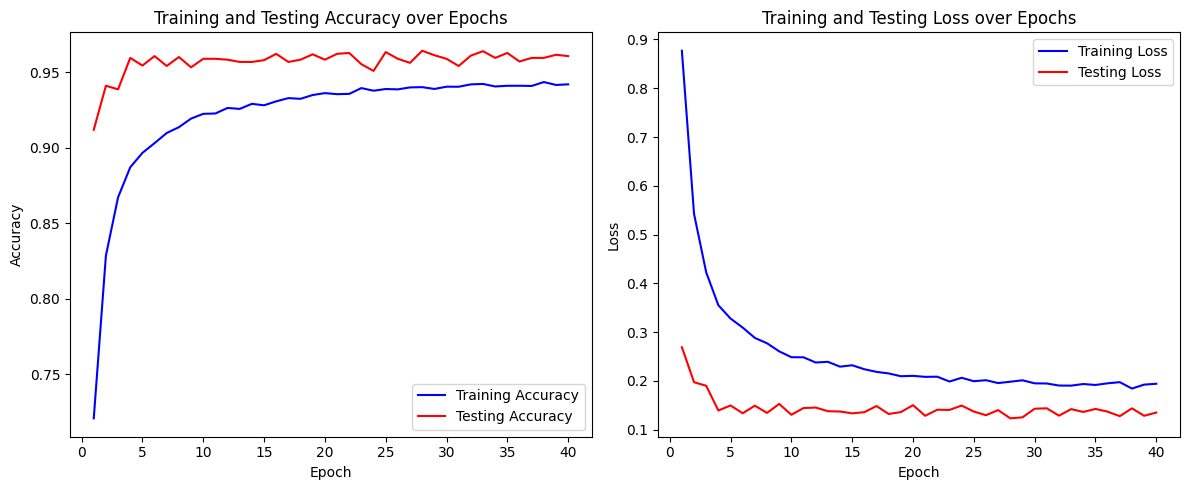


Weighted Precision: 0.9613
Weighted Recall: 0.9607
Weighted F1 Score: 0.9607

Test Accuracy of the model on the test set: 96.07 %


In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot training and testing accuracy
axes[0].plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy', color='blue')
axes[0].plot(range(1, num_epochs + 1), test_acc_list, label='Testing Accuracy', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Testing Accuracy over Epochs')
axes[0].legend()

# Plot training and testing loss
axes[1].plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss', color='blue')
axes[1].plot(range(1, num_epochs + 1), test_loss_list, label='Testing Loss', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Testing Loss over Epochs')
axes[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()
alexnet_model.eval()

# Lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for (images, labels) in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet_model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Collect predictions and ground truth labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Precision, Recall, and F1 Score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Print the results
#print('Confusion Matrix:\n', conf_matrix)
print('\nWeighted Precision: {:.4f}'.format(precision))
print('Weighted Recall: {:.4f}'.format(recall))
print('Weighted F1 Score: {:.4f}'.format(f1))
print('\nTest Accuracy of the model on the test set: {:.2f} %'.format(accuracy * 100))

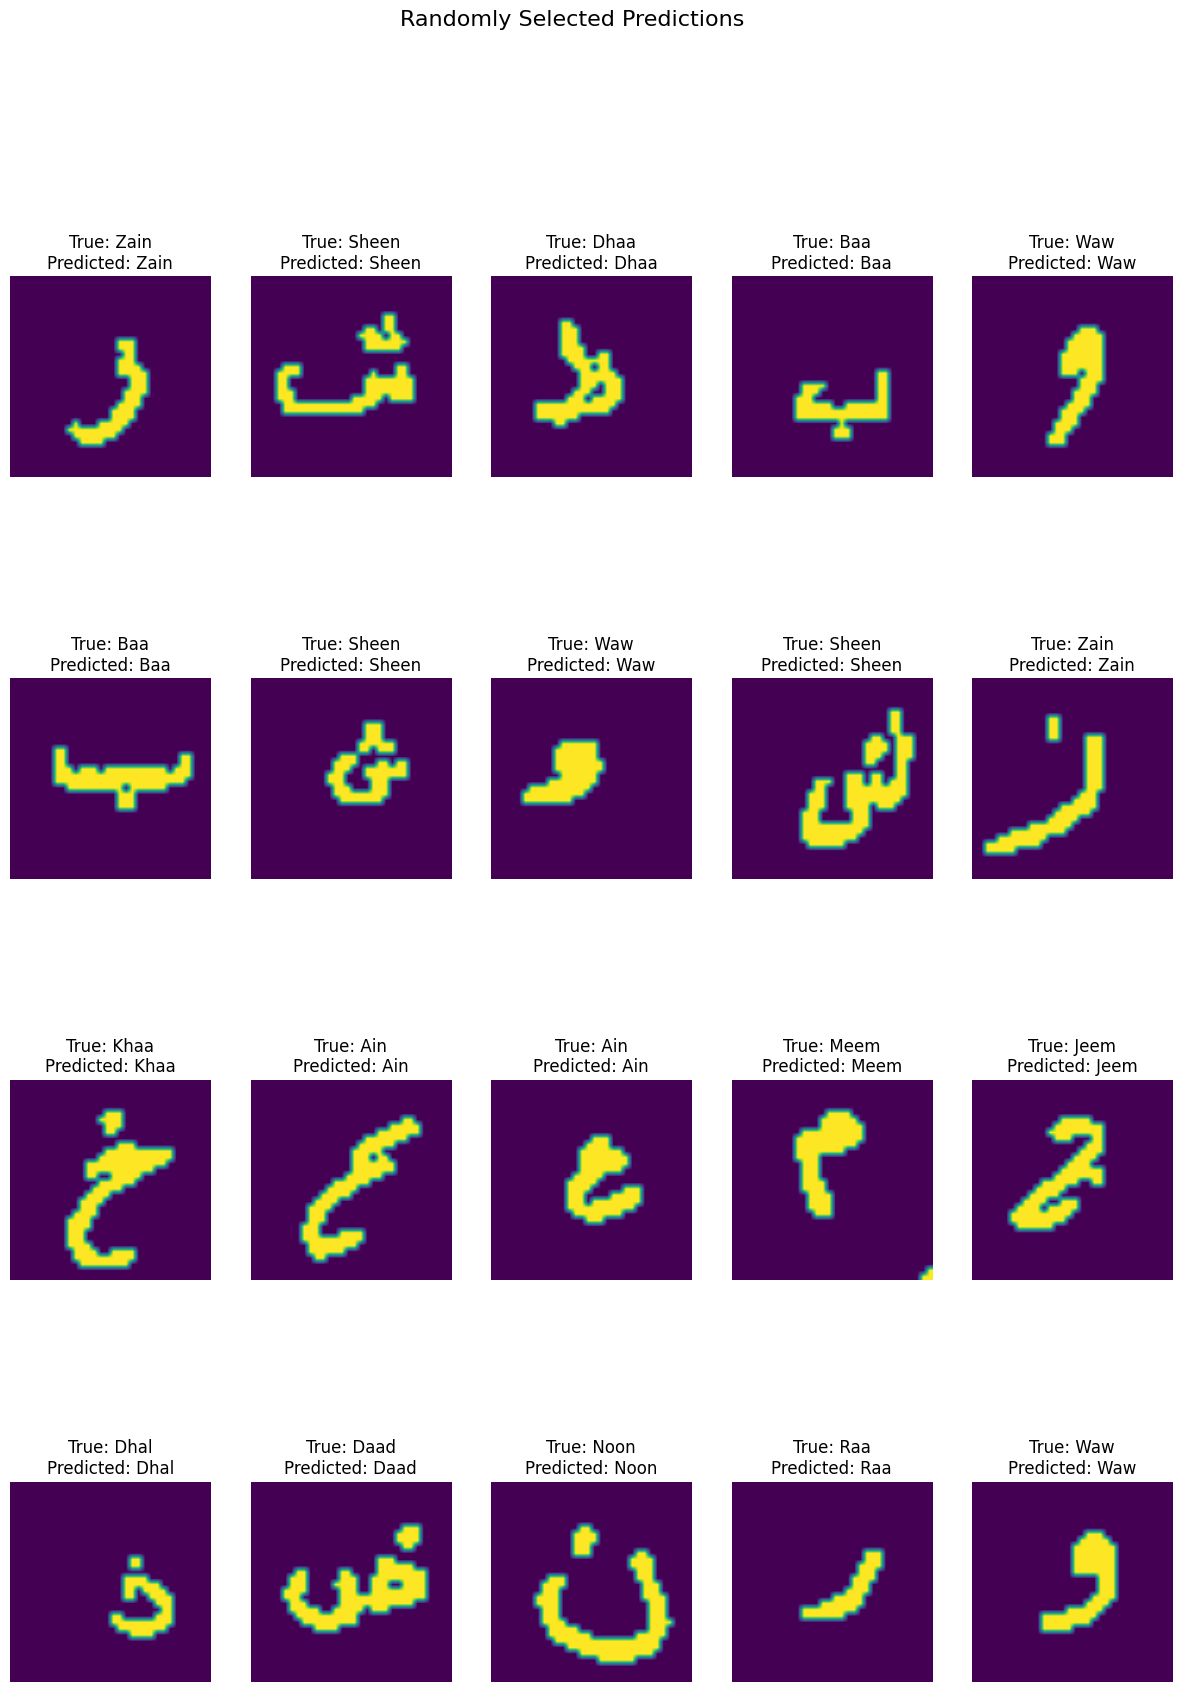

In [36]:
alexnet_model.eval()

# Lists to store predictions, ground truth labels, and images
all_predictions = []
all_labels = []
all_images = []

with torch.no_grad():
    for (images, labels) in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet_model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Collect predictions, ground truth labels, and images
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu().numpy())

# Get 9 random indices
random_indices = np.random.choice(len(all_images), 20, replace=False)

# Select images, labels, and predictions for the random indices
selected_images = [all_images[i] for i in random_indices]
selected_labels = [all_labels[i] for i in random_indices]
selected_predictions = [all_predictions[i] for i in random_indices]

# Plot the selected images
plot_images(selected_images, selected_labels, selected_predictions, title='Randomly Selected Predictions')

# **Res-NEt50**

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms, models

# Import ResNet-50 model
resnet50_model = models.resnet50(weights=None)

# Modify the first layer if using 1-channel images
resnet50_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final layer
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 28)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_model.to(device)

# Image transformations
larger_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(larger_size),
    transforms.ToTensor(),
])

# Assume CustomImageDataset and NoisyImageDataset are defined elsewhere
# ...

# Creating datasets
train_image_dataset_augmented = ConcatDataset([
    CustomImageDataset(train_path, transform=rotate_transform),
    CustomImageDataset(train_path, transform=shift_transform),
    CustomImageDataset(train_path, transform=shear_transform),
    CustomImageDataset(train_path, transform=transform),
    NoisyImageDataset(train_path, transform=gaussian_noise_transform),
    CustomImageDataset(train_path, transform=blur_transform)
])

# Data loaders
loader = DataLoader(train_image_dataset_augmented, batch_size=128, shuffle=True)
test_dataset = CustomImageDataset(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [25]:

num_epochs = 10
learning_rate = 0.001


current_patience = 0 
patience = 5 

total_step = len(loader)




train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []

resnet50_model.train()
for epoch in range(num_epochs):
    resnet50_model.train()
    epoch_train_loss = 0.0
    epoch_train_correct = 0
    epoch_train_total = 0
    for i, data in enumerate(loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # Forward pass
        outputs = resnet50_model(images)
        loss = criterion(outputs, labels)
        #loss_list.append(loss.item())
        epoch_train_loss += loss.item()


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        #acc_list.append(correct / total)

        epoch_train_correct += correct
        epoch_train_total += total

        if (i + 1) % 300 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
    resnet50_model.eval()
    epoch_test_loss = 0.0
    epoch_test_correct = 0
    epoch_test_total = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()
            epoch_test_correct += correct
            epoch_test_total += total

    avg_test_loss = epoch_test_loss / len(test_loader)
    avg_test_acc = epoch_test_correct / epoch_test_total

    avg_train_loss = epoch_train_loss / len(loader)
    avg_train_acc = epoch_train_correct / epoch_train_total

    if epoch > 0 and avg_test_loss < test_loss_list[-1]:
        current_patience = 0
    else:
        current_patience += 1

    if current_patience >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break
    test_loss_list.append(avg_test_loss)
    test_acc_list.append(avg_test_acc)
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)


    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%,, test Loss: {:.4f}, test Accuracy: {:.2f}%'
      .format(epoch + 1, num_epochs, avg_train_loss, avg_train_acc * 100,avg_test_loss, avg_test_acc* 100))
print('\n--- Finished ---\n')        
            
            
            
            


Epoch [1/10], Step [300/630], Loss: 0.4639, Accuracy: 90.62%
Epoch [1/10], Step [600/630], Loss: 0.4019, Accuracy: 88.28%
Epoch [1/10], Train Loss: 0.7761, Train Accuracy: 76.78%,, test Loss: 0.3304, test Accuracy: 88.99%
Epoch [2/10], Step [300/630], Loss: 0.3555, Accuracy: 85.94%
Epoch [2/10], Step [600/630], Loss: 0.2172, Accuracy: 92.97%
Epoch [2/10], Train Loss: 0.3165, Train Accuracy: 90.07%,, test Loss: 0.1771, test Accuracy: 94.49%
Epoch [3/10], Step [300/630], Loss: 0.1619, Accuracy: 94.53%
Epoch [3/10], Step [600/630], Loss: 0.2513, Accuracy: 92.19%
Epoch [3/10], Train Loss: 0.2564, Train Accuracy: 91.96%,, test Loss: 0.1972, test Accuracy: 94.26%
Epoch [4/10], Step [300/630], Loss: 0.2663, Accuracy: 91.41%
Epoch [4/10], Step [600/630], Loss: 0.2510, Accuracy: 92.97%
Epoch [4/10], Train Loss: 0.2167, Train Accuracy: 93.08%,, test Loss: 0.1737, test Accuracy: 94.64%
Epoch [5/10], Step [300/630], Loss: 0.1880, Accuracy: 96.88%
Epoch [5/10], Step [600/630], Loss: 0.2313, Accurac

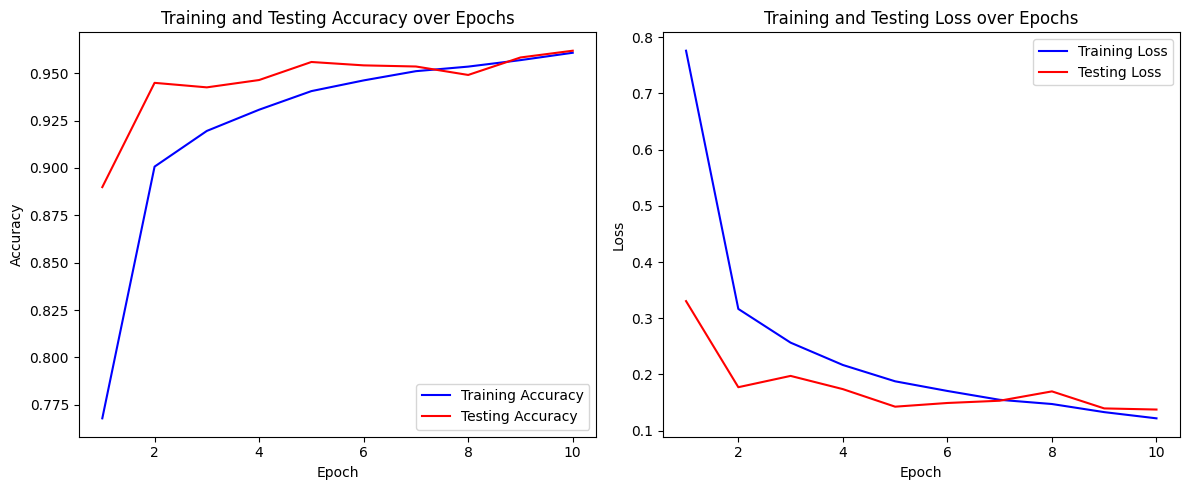


Weighted Precision: 0.9626
Weighted Recall: 0.9619
Weighted F1 Score: 0.9618

Test Accuracy of the model on the test set: 96.19 %


In [28]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot training and testing accuracy
axes[0].plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy', color='blue')
axes[0].plot(range(1, num_epochs + 1), test_acc_list, label='Testing Accuracy', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Testing Accuracy over Epochs')
axes[0].legend()

# Plot training and testing loss
axes[1].plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss', color='blue')
axes[1].plot(range(1, num_epochs + 1), test_loss_list, label='Testing Loss', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Testing Loss over Epochs')
axes[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()
resnet50_model.eval()

# Lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for (images, labels) in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50_model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Collect predictions and ground truth labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Precision, Recall, and F1 Score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Print the results
#print('Confusion Matrix:\n', conf_matrix)
print('\nWeighted Precision: {:.4f}'.format(precision))
print('Weighted Recall: {:.4f}'.format(recall))
print('Weighted F1 Score: {:.4f}'.format(f1))
print('\nTest Accuracy of the model on the test set: {:.2f} %'.format(accuracy * 100))

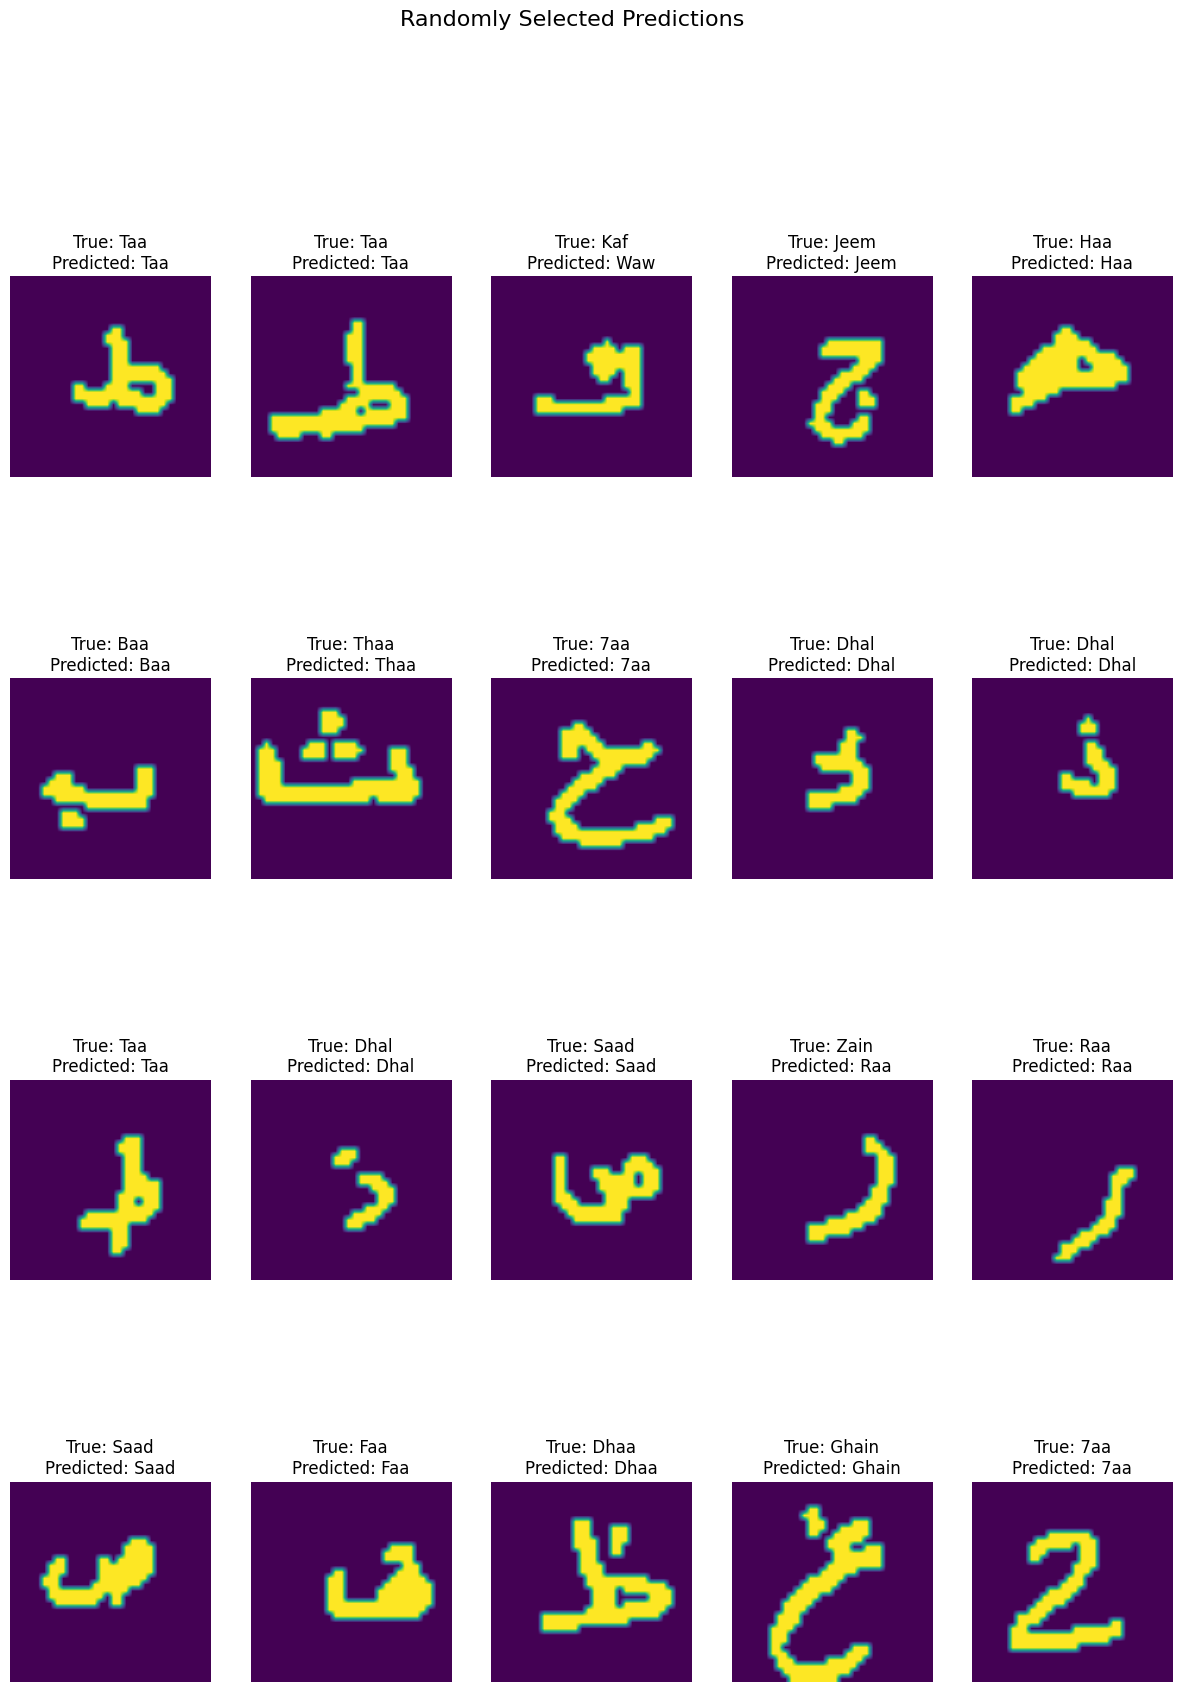

In [27]:
resnet50_model.eval()

# Lists to store predictions, ground truth labels, and images
all_predictions = []
all_labels = []
all_images = []

with torch.no_grad():
    for (images, labels) in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50_model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Collect predictions, ground truth labels, and images
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu().numpy())

# Get 9 random indices
random_indices = np.random.choice(len(all_images), 20, replace=False)

# Select images, labels, and predictions for the random indices
selected_images = [all_images[i] for i in random_indices]
selected_labels = [all_labels[i] for i in random_indices]
selected_predictions = [all_predictions[i] for i in random_indices]

# Plot the selected images
plot_images(selected_images, selected_labels, selected_predictions, title='Randomly Selected Predictions')